## Visualization — PR Curves & Class Imbalance

This notebook renders the *compulsory* figures for the report:
 - Class imbalance histogram (Validation vs Test)
 - Validation PR curves (LSTM-AE vs MAE)
 - Test PR curves with warm-up calibration (LSTM-AE vs MAE)

It reads precomputed arrays from `artifacts/` so results are **reproducible** without retraining.


0) Setup & Sanity Checks
 - Set `ART` to your artifacts folder (defaults to `./artifacts`)
 - Verify required files exist before plotting


In [2]:
from pathlib import Path
import os, json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Path to artifacts (change if needed)
ART = Path("artifacts")

print("ART:", ART.resolve())
assert ART.exists(), "artifacts/ folder not found next to this notebook."


ART: C:\Users\LENOVO\Comaprison_of_models\artifacts


In [3]:
required = [
    "X_train_normal.npy", "X_val.npy", "y_val.npy",
    "X_test.npy", "y_test.npy",
    "scores_lstm_val.npy", "scores_mae_val.npy",
    "scores_lstm_test.npy", "scores_mae_test.npy",
    "scores_lstm_test_varnorm_warmup.npy", "scores_mae_test_warmup.npy",
    "pr_lstm_val.npy", "pr_lstm_test_warmup.npy", "pr_mae_val.npy", "pr_mae_test_warmup.npy"
]

print("Checking preprocessing/training artifacts:")
for f in required:
    print(f"{f:40} ->", "OK" if (ART/f).exists() else "MISSING")


Checking preprocessing/training artifacts:
X_train_normal.npy                       -> OK
X_val.npy                                -> OK
y_val.npy                                -> OK
X_test.npy                               -> OK
y_test.npy                               -> OK
scores_lstm_val.npy                      -> OK
scores_mae_val.npy                       -> OK
scores_lstm_test.npy                     -> OK
scores_mae_test.npy                      -> OK
scores_lstm_test_varnorm_warmup.npy      -> OK
scores_mae_test_warmup.npy               -> OK
pr_lstm_val.npy                          -> OK
pr_lstm_test_warmup.npy                  -> OK
pr_mae_val.npy                           -> OK
pr_mae_test_warmup.npy                   -> OK


## 1) Class Imbalance (Validation & Test)
Shows label distribution to contextualize PR curves under class imbalance.


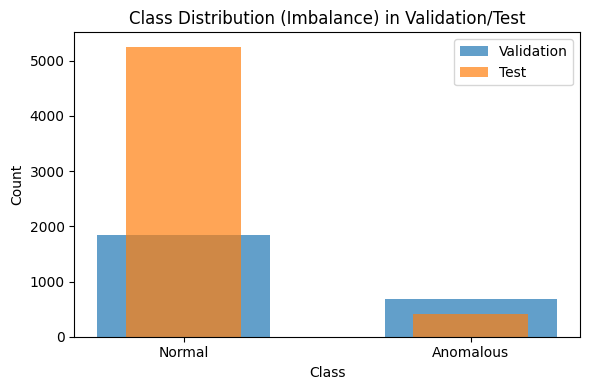

Saved: C:\Users\LENOVO\Comaprison_of_models\artifacts\figures\val_test_label_hist.png


In [4]:
ART = Path(r"C:\Users\LENOVO\Comaprison_of_models\artifacts")
FIG = ART / "figures"
FIG.mkdir(exist_ok=True, parents=True)

# Load validation labels (or test/train as needed)
y_val = np.load(ART/"y_val.npy")
y_test = np.load(ART/"y_test.npy")

# Plot histogram
plt.figure(figsize=(6,4))
plt.hist(y_val, bins=[-0.5,0.5,1.5], rwidth=0.6, alpha=0.7, label="Validation")
plt.hist(y_test, bins=[-0.5,0.5,1.5], rwidth=0.4, alpha=0.7, label="Test")
plt.xticks([0,1], ["Normal","Anomalous"])
plt.xlabel("Class"); plt.ylabel("Count")
plt.title("Class Distribution (Imbalance) in Validation/Test")
plt.legend()
plt.tight_layout()
plt.savefig(FIG/"val_test_label_hist.png", dpi=150)
plt.show()

print("Saved:", FIG/"val_test_label_hist.png")

## 2) Helper: Load & Plot PR Curves
The `.npy` files are shaped as columns: `[recall, precision, threshold]`.


In [5]:
FIG = ART / "figures" 
FIG.mkdir(exist_ok=True, parents=True)

def load_pr(npy_path: Path):
    a = np.load(npy_path)
    return a[:,0], a[:,1]  # recall, precision

def plot_pr_combo(pairs, title, out_name):
    plt.figure()
    for label, npy in pairs:
        if npy.exists():
            r, p = load_pr(npy)
            plt.plot(r, p, label=label, linewidth=2)
        else:
            print("Missing:", npy.name)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(title)
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    out_path = FIG/out_name
    plt.savefig(out_path, dpi=150)
    plt.show()
    print("Saved:", out_path)

## 3) Validation PR — LSTM-AE vs MAE
Uses `pr_lstm_val.npy` and `pr_mae_val.npy`.


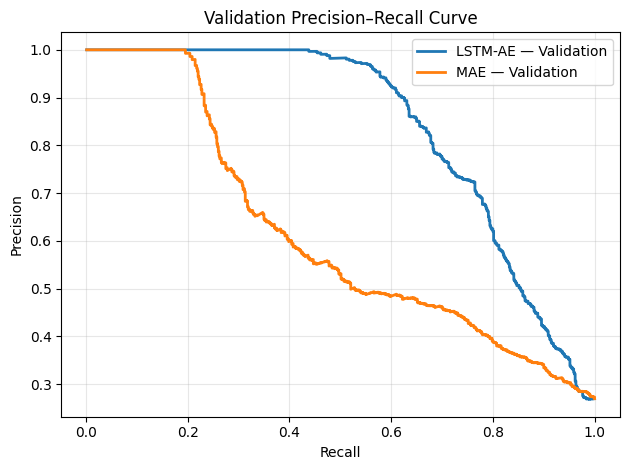

Saved: C:\Users\LENOVO\Comaprison_of_models\artifacts\figures\pr_VAL_LSTM_vs_MAE.png


In [8]:
plot_pr_combo(
    [
        ("LSTM-AE — Validation", ART/"pr_lstm_val.npy"),
        ("MAE — Validation",     ART/"pr_mae_val.npy"),
    ],
    "Validation Precision–Recall Curve",
    "pr_VAL_LSTM_vs_MAE.png"
)


## 4) Test PR (Warm-Up Calibration) — LSTM-AE vs MAE
Uses `pr_lstm_test_warmup.npy` and `pr_mae_test_warmup.npy`.


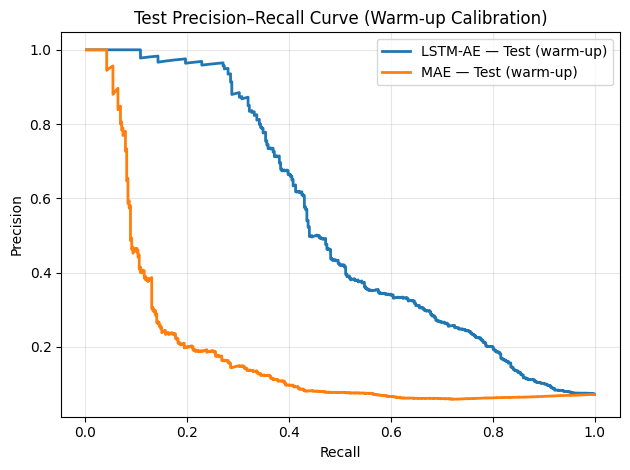

Saved: C:\Users\LENOVO\Comaprison_of_models\artifacts\figures\pr_TEST_warm_LSTM_vs_MAE.png


In [9]:
plot_pr_combo(
    [
        ("LSTM-AE — Test (warm-up)", ART/"pr_lstm_test_warmup.npy"),
        ("MAE — Test (warm-up)",     ART/"pr_mae_test_warmup.npy"),
    ],
    "Test Precision–Recall Curve (Warm-up Calibration)",
    "pr_TEST_warm_LSTM_vs_MAE.png"
)


## Notes
- Both figures were generated entirely from `.npy` artifacts stored during preprocessing and evaluation.
- This confirms the reproduciblility of the workflow: results can be regenerated without retraining.
- Validation PR curve supports threshold selection.
- Test PR curve (warm-up) highlights the final comparative performance of LSTM-AE vs MAE.